In [1]:
import itertools
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

import sys
sys.path.append("../src")
import utils
import make_data as md

In [2]:
lon, lat = -97.385551, 41.964567

In [3]:
lon_m, lat_m, epsg_utm = utils.convert_degree_to_meters(lon, lat)

#### Want a field that is approx 10 acres (ie 40468 square meters)

Propose a field that is 100 meters wide by 400 meters long

`lon_m` and `lat_m` to be designated as the top right-corner of the field

In [4]:
lon_m_top_left = lon_m - 100
lat_m_top_left = lat_m

lon_m_bottom_left = lon_m_top_left
lat_m_bottom_left = lat_m - 400

lon_m_bottom_right = lon_m
lat_m_bottom_right = lat_m_bottom_left

In [5]:
list_tuple_coords = [
    (lon_m, lat_m),
    (lon_m_top_left, lat_m_top_left),
    (lon_m_bottom_left, lat_m_bottom_left),
    (lon_m_bottom_right, lat_m_bottom_right),
]

polygon_utm = utils.create_polygon_from_list_tuple(list_tuple_coords)

In [6]:
polygon_utm.area

40000.0

In [7]:
list_tuple_coords_degrees = [
    utils.convert_meters_to_degree(lon, lat, epsg_utm) for (lon, lat) in list_tuple_coords
]

In [8]:
list_tuple_coords_degrees

[(-97.38555100000002, 41.964566999999995),
 (-97.38675732371843, 41.96458396139896),
 (-97.3868481872366, 41.96098270170655),
 (-97.38564193139067, 41.96096574243743)]

In [9]:
polygon = utils.create_polygon_from_list_tuple(list_tuple_coords_degrees)

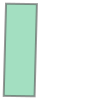

In [10]:
polygon

## Now that I have the boundary conditions of a field, I will populate that area with dummy data
* assume 2 treatments and a control, that is T1 | Control | T2
* Each treatment is comprised of 2 harvester passes
  

want each harvester pass to be 5 meters

In [11]:
pass_width = 5 # meters
buffer = 1 # meter
pass_length = 100 # meters
points_per_pass = 10

In [12]:
tnames = ["T1", "Control", "T2"]
effect_size = [5, 0, 1]
treatment_sds_pct= [0.2, 0.2, 0.15]
passes_per_treatment = 2

In [29]:
df_block = md.make_dummy_block(
    passes_per_treatment=passes_per_treatment,
    pass_width=pass_width,
    buffer=buffer,
    pass_length=pass_length,
    points_per_pass=points_per_pass,
    effect_size=effect_size,
    tnames=tnames,
)

In [30]:
df_block = df_block.assign(
    longitude_m=lambda x: x.x_lon + lon_m,
    latitude_m=lambda x: x.y_lat + lat_m
)

In [31]:
df_block[['longitude', 'latitude']] = df_block.apply(
    lambda row: utils.convert_meters_to_degree(row['longitude_m'], row['latitude_m'], epsg_utm), 
    axis=1, 
    result_type='expand'
)

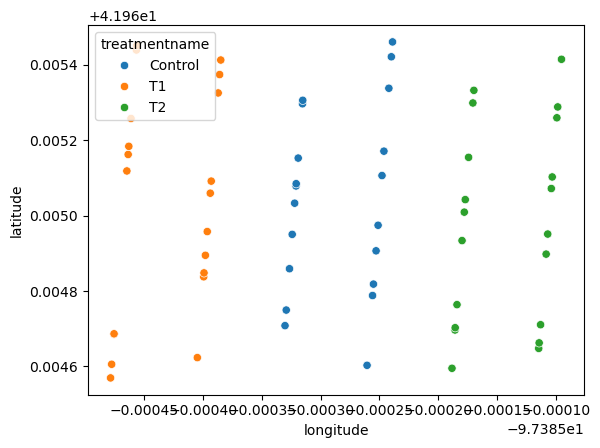

In [32]:
sns.scatterplot(
    data=df_block,
    x="longitude",
    y="latitude",
    hue="treatmentname"
);

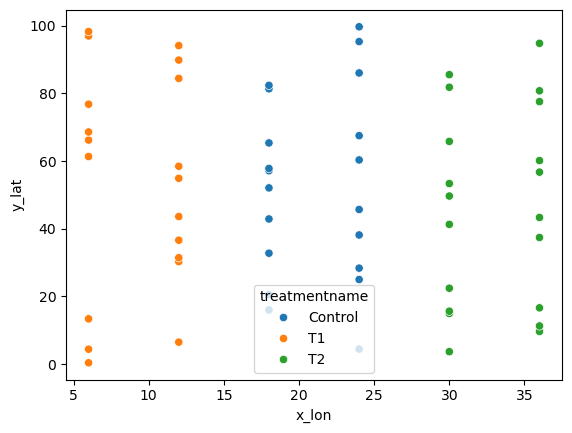

In [33]:
sns.scatterplot(
    data=df_block,
    x="x_lon",
    y="y_lat",
    hue="treatmentname"
);

In [34]:
df_block.head()

,treatmentname,x_lon,y_lat,value,longitude_m,latitude_m,longitude,latitude
0,Control,18,16.022956,0.012193,633798.881693,4.647119e+06,-97.385330,41.964708
1,Control,18,20.609823,-0.180381,633798.881693,4.647123e+06,-97.385329,41.964749
2,Control,18,32.777281,-0.661777,633798.881693,4.647135e+06,-97.385326,41.964859
3,Control,18,42.888905,-0.365978,633798.881693,4.647146e+06,-97.385324,41.964950
4,Control,18,52.066936,-0.332623,633798.881693,4.647155e+06,-97.385322,41.965033


In [35]:
gdf_block = gpd.GeoDataFrame(
    df_block.drop(columns=["x_lon", "y_lat"]),
    geometry=gpd.points_from_xy(df_block.longitude, df_block.latitude),
    crs="EPSG:4326"
)

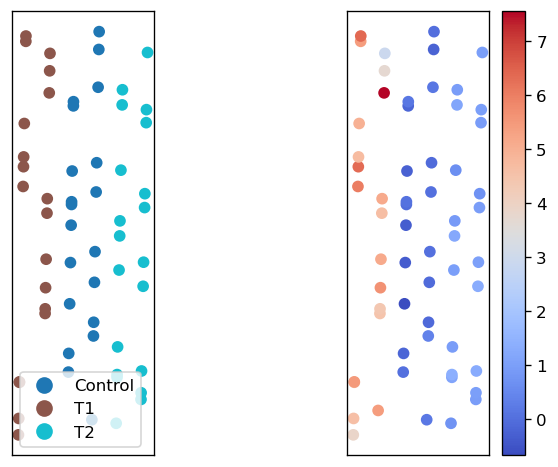

In [36]:
fig, ax = plt.subplots(1, 2, dpi=120, sharey=True, sharex=True)
gdf_block.plot("treatmentname", ax=ax[0], legend=True);
gdf_block.plot("value", ax=ax[1], legend=True, cmap="coolwarm");
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

In [37]:
gdf_block.head()

,treatmentname,value,longitude_m,latitude_m,longitude,latitude,geometry
0,Control,0.012193,633798.881693,4.647119e+06,-97.385330,41.964708,POINT (-97.38533 41.96471)
1,Control,-0.180381,633798.881693,4.647123e+06,-97.385329,41.964749,POINT (-97.38533 41.96475)
2,Control,-0.661777,633798.881693,4.647135e+06,-97.385326,41.964859,POINT (-97.38533 41.96486)
3,Control,-0.365978,633798.881693,4.647146e+06,-97.385324,41.964950,POINT (-97.38532 41.96495)
4,Control,-0.332623,633798.881693,4.647155e+06,-97.385322,41.965033,POINT (-97.38532 41.96503)


In [38]:
gdf_block_utm = gpd.GeoDataFrame(
    df_block.drop(columns=["x_lon", "y_lat", "longitude", "latitude"]),
    geometry=gpd.points_from_xy(df_block.longitude_m, df_block.latitude_m),
    crs=epsg_utm
)

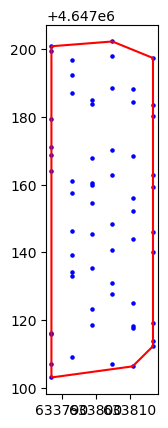

In [39]:
# Create a convex hull polygon around all points
convex_hull = gdf_block_utm.geometry.union_all().convex_hull

# Visualize the convex hull
gdf_hull = gpd.GeoDataFrame(geometry=[convex_hull], crs=gdf_block_utm.crs)

# Plot the original points and the convex hull
ax = gdf_block_utm.plot(color="blue", marker="o", markersize=5)
gdf_hull.boundary.plot(ax=ax, color="red");


In [40]:
gdf_hull.area

0    2858.388541
dtype: float64

equivalent to approx 0.7 acre

#### Create a GP for spatial_effect

yield ~ intercept + delta_sym + delta_elev + delta_spatial_effect

In [54]:
x = gdf_block.longitude_m.values - gdf_block.longitude_m.min()
y = gdf_block.latitude_m.values - gdf_block.latitude_m.min()
spatial_effect = md.make_linear_pattern(x=x, y=y, c=2)

Sampling: [f_rotated_, ℓ]


In [55]:
X, Y = np.meshgrid(x, y)

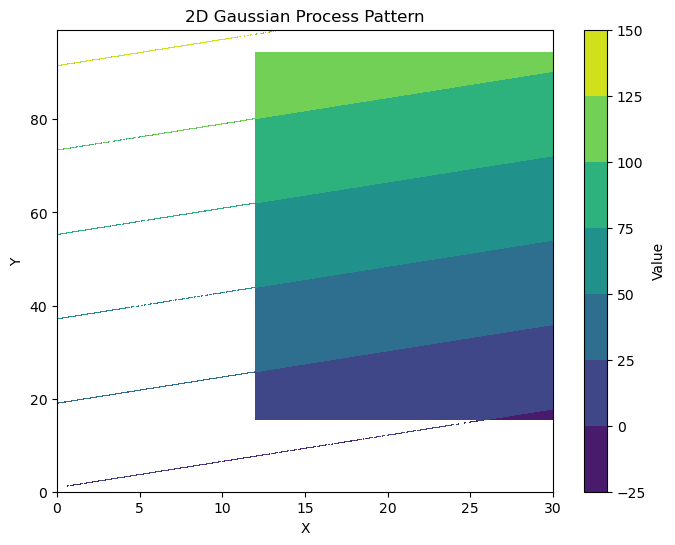

In [60]:
# Plot the 2D GP pattern
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, spatial_effect,)
plt.colorbar(label="Value")
plt.title("2D Gaussian Process Pattern")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [57]:
x

array([12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 18., 18., 18.,
       18., 18., 18., 18., 18., 18., 18.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
        6., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 30., 30.,
       30., 30., 30., 30., 30., 30., 30., 30.])

In [58]:
y

array([15.61744124, 20.2043088 , 32.37176675, 42.48339105, 51.66142155,
       56.73474505, 57.4036157 , 64.94173897, 80.92661072, 81.95337284,
        4.05012383, 24.59415325, 27.95630737, 37.75508418, 45.27760069,
       59.91354668, 67.0909703 , 85.61058931, 94.8761765 , 99.25018484,
        0.        ,  4.02054887, 12.89230006, 12.99173829, 60.92716764,
       65.77911759, 68.18063413, 76.37826698, 96.53330162, 97.83581049,
        6.0939032 , 29.88054179, 31.03086608, 36.20904575, 43.19758135,
       54.49270398, 58.04910815, 84.00127535, 89.41411004, 93.69471272,
        3.28697249, 14.56329908, 15.23637742, 22.02438245, 40.88150636,
       49.25483545, 52.94285915, 65.38357946, 81.39277203, 85.10705966,
        9.2550689 , 10.88605577, 16.23086016, 37.01196736, 42.91763584,
       56.31803327, 59.7249403 , 77.14575569, 80.33946079, 94.36387801])

In [59]:
spatial_effect

array([[ 11.0053118 ,  11.00280389,  11.00402339, ...,  -2.98800768,
         -2.98762151,  -2.98853257],
       [ 17.32942494,  17.32906059,  17.33035108, ...,   3.33812838,
          3.33463603,   3.33640947],
       [ 34.1082155 ,  34.10860023,  34.10916119, ...,  20.11462897,
         20.11594649,  20.11515942],
       ...,
       [ 95.84957566,  95.84984222,  95.84934395, ...,  81.85802776,
         81.85802013,  81.85431356],
       [100.25311853, 100.25220151, 100.25362556, ...,  86.2612297 ,
         86.26057758,  86.26183161],
       [119.59296688, 119.59389548, 119.59259299, ..., 105.60119577,
        105.59947714, 105.60044211]])

In [50]:
spatial_effect.mean()

-0.03402567439586195

In [51]:
spatial_effect.std()

0.8513703961405259

In [52]:
spatial_effect.min()

-2.2259981746175037